In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  # default is 'last_expr'

%load_ext autoreload
%autoreload 2

In [ ]:
import io
import json
import os
import random

from azure.cosmos.cosmos_client import CosmosClient
from PIL import Image
from tqdm import tqdm

import sys
sys.path.append('../../../')  # CameraTraps repository base dir

from data_management.annotations import annotation_constants
from data_management.megadb.megadb_utils import MegadbUtils
from visualization import visualization_utils

Please do not commit modified versions of this notebook.

# Query for data

This notebook demonstrates the workflow to compile desired sequences of images by querying metadata and downloading the images stored in blob storage.

See the programs that Chris prepared here (internal): https://celads.visualstudio.com/CELA%20Data%20Science%20And%20Analytics/_git/DSnA.CameraTrap?path=%2FPython%2Fclientpr.py

## Connect to the Cosmos DB instance

`COSMOS_ENDPOINT` and `COSMOS_KEY` need to be environment variables.

In [6]:
url = os.environ['COSMOS_ENDPOINT']
key = os.environ['COSMOS_KEY']
client = CosmosClient(url, credential=key)

database = client.get_database_client('camera-trap')
container_sequences = database.get_container_client('sequences')

## Get the `datasets` table
which records the location and access levels of each dataset.

In [8]:
%%time

megadb_utils = MegadbUtils()
datasets = megadb_utils.get_datasets_table()

print('Length of results:', len(datasets))

Length of results: 26
CPU times: user 39.8 ms, sys: 5.21 ms, total: 45 ms
Wall time: 789 ms


In [ ]:
datasets.keys()  # which datasets are ingested

## Query for sequences

Example: top 100 sequences from a given dataset where at least one image has bounding box annotations.

In [12]:
desired_dataset = 'snapshotserengeti'

In [13]:
%%time

result_iterable = container_sequences.query_items(
    query='''
SELECT TOP @top_n seq
FROM sequences seq
WHERE (SELECT VALUE COUNT(im) FROM im IN seq.images WHERE ARRAY_LENGTH(im.bbox) >= 0) > 0
''',
    parameters=[
        dict(name='@top_n', value=100)
    ],
    partition_key=desired_dataset
)

CPU times: user 92 µs, sys: 0 ns, total: 92 µs
Wall time: 96.1 µs


In [14]:
results = [{k: v for k, v in r['seq'].items() if not k.startswith('_')} for r in result_iterable]

In [17]:
results[-1]

{'dataset': 'snapshotserengeti',
 'seq_id': 'SER_S3#S07#12#263',
 'location': 'S07',
 'images': [{'id': 'S3/S07/S07_R12/S3_S07_R12_IMAG0760',
   'frame_num': 2,
   'file': 'S3/S07/S07_R12/S3_S07_R12_IMAG0760.JPG',
   'bbox': [{'category': 'animal', 'bbox': [0.024, 0.211, 0.525, 0.45]}]},
  {'id': 'S3/S07/S07_R12/S3_S07_R12_IMAG0761',
   'frame_num': 3,
   'file': 'S3/S07/S07_R12/S3_S07_R12_IMAG0761.JPG',
   'bbox': [{'category': 'animal', 'bbox': [0.054, 0.204, 0.524, 0.435]}]},
  {'id': 'S3/S07/S07_R12/S3_S07_R12_IMAG0759',
   'frame_num': 1,
   'file': 'S3/S07/S07_R12/S3_S07_R12_IMAG0759.JPG',
   'bbox': [{'category': 'animal', 'bbox': [0, 0.215, 0.501, 0.429]}]}],
 'class': ['elephant'],
 'datetime': '2011-12-26 15:34:23',
 'standing': 0.27,
 'subject_id': 'ASG000az8d',
 'count': '1',
 'moving': 0.91,
 'young_present': 0,
 'resting': 0,
 'season': 'S3',
 'interacting': 0,
 'id': 'd662be6c-6ef9-4340-af7b-43ddec108104'}

## Download sample images and visualize labels

For large batches, download using `multiprocessing.ThreadPool`.

From dataset snapshotserengeti. Image file: S3/E05/E05_R11/S3_E05_R11_IMAG0314.JPG. Class labels: ['elephant']


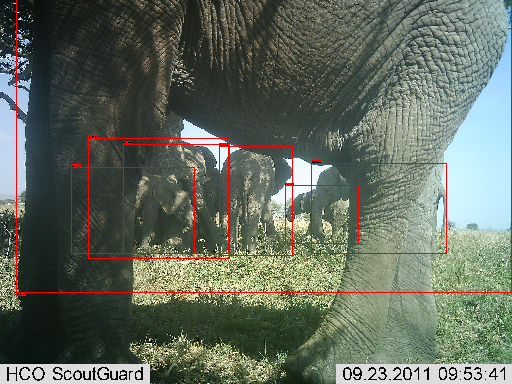

From dataset snapshotserengeti. Image file: S3/E05/E05_R11/S3_E05_R11_IMAG0315.JPG. Class labels: ['elephant']


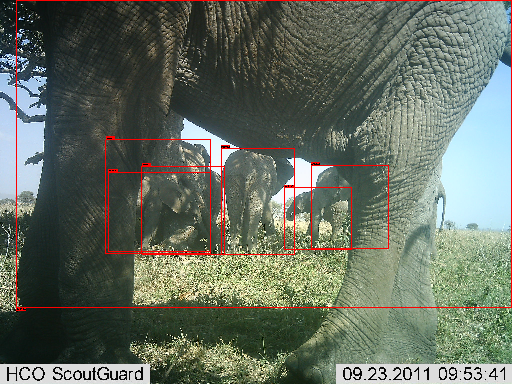

From dataset snapshotserengeti. Image file: S3/E05/E05_R11/S3_E05_R11_IMAG0316.JPG. Class labels: ['elephant']


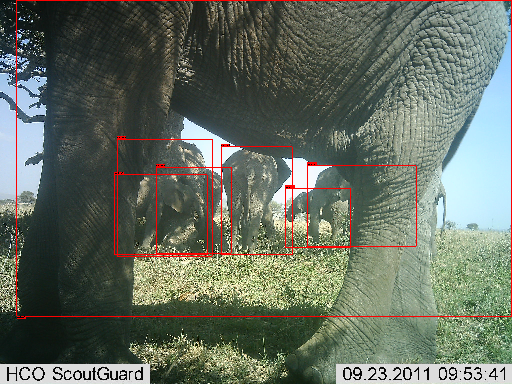

From dataset snapshotserengeti. Image file: S2/E02/E02_R1/S2_E02_R1_PICT0410.JPG. Class labels: ['batearedfox']


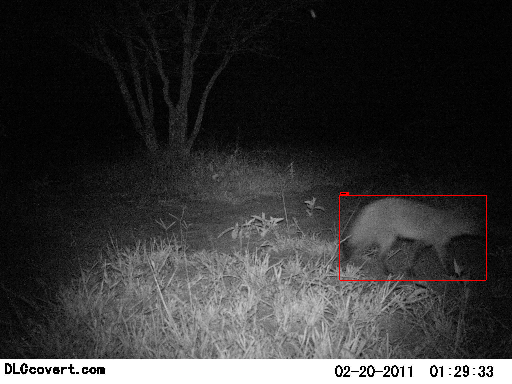

From dataset snapshotserengeti. Image file: S2/E02/E02_R1/S2_E02_R1_PICT0411.JPG. Class labels: ['batearedfox']


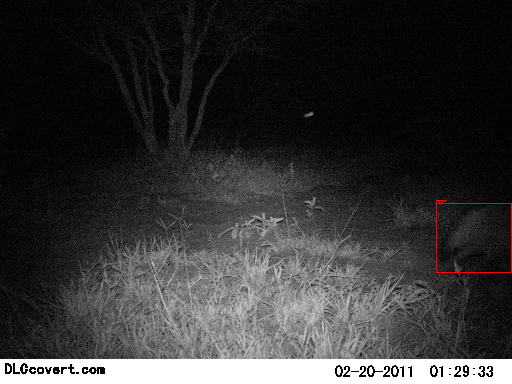

From dataset snapshotserengeti. Image file: S2/E02/E02_R1/S2_E02_R1_PICT0409.JPG. Class labels: ['batearedfox']


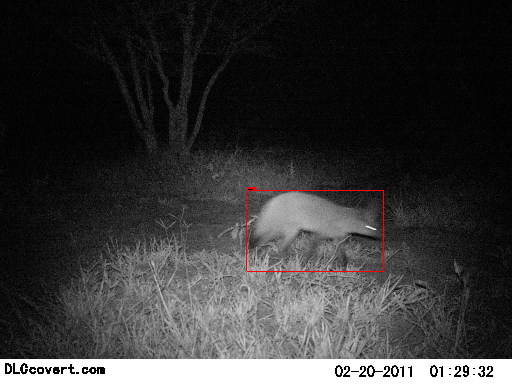

In [149]:
sample_size = 2
sample_res = random.sample(results, sample_size)

for seq in sample_res:
    dataset = seq['dataset']

    for im in seq['images']:
        if 'bbox' not in im or len(im['bbox']) == 0:
            continue

        # prepend the prefix in blob container to the image file path recorded
        filename = im['file']
        image_blob_path = MegadbUtils.get_full_path(datasets, dataset, filename)

        stream = io.BytesIO()
        storage_client = MegadbUtils.get_storage_client(datasets, dataset)
        storage_client.download_blob(image_blob_path).readinto(stream)

        image = Image.open(stream)
        visualization_utils.render_megadb_bounding_boxes(im['bbox'], image)
        im_class = im.get('class', [])
        if len(im_class) < 1:
            im_class = seq.get('class', [])

        print(f'From dataset {dataset}. Image file: {filename}. Class labels: {im_class}')
        image.resize((image.width // 4, image.height // 4))